#### 1. Imports

In [6]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Paths & Data loading

In [7]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_7"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(30, 6), y:(30,)


#### 3. Add weekly data

In [8]:
# --- Weekly results ---
week_data = [
    (np.array([0.395841, 0.283585, 0.132240, 0.259320, 0.371154, 0.897563]), 1.432575873879877),  # W1
    (np.array([0.221213, 0.300122, 0.168952, 0.224512, 0.389654, 0.859427]),  1.6575349814836515), # W2
    (np.array([0.087739, 0.209465, 0.209361, 0.156530, 0.372774, 0.896630]),  1.3926590883489465), # W3
    (np.array([0.069169, 0.257883, 0.050673, 0.175079, 0.365050, 0.828608]),  1.516143729359471), # W4
    (np.array([0.140087, 0.400824, 0.045511, 0.250025, 0.392652, 0.886065]), 1.159913395061865), # W5
    (np.array([0.086489, 0.130677, 0.350544, 0.124198, 0.371560, 0.800790]), 1.9394187218936827), # W6
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(36, 6), y:(36,)


#### 4. Quick Visualization

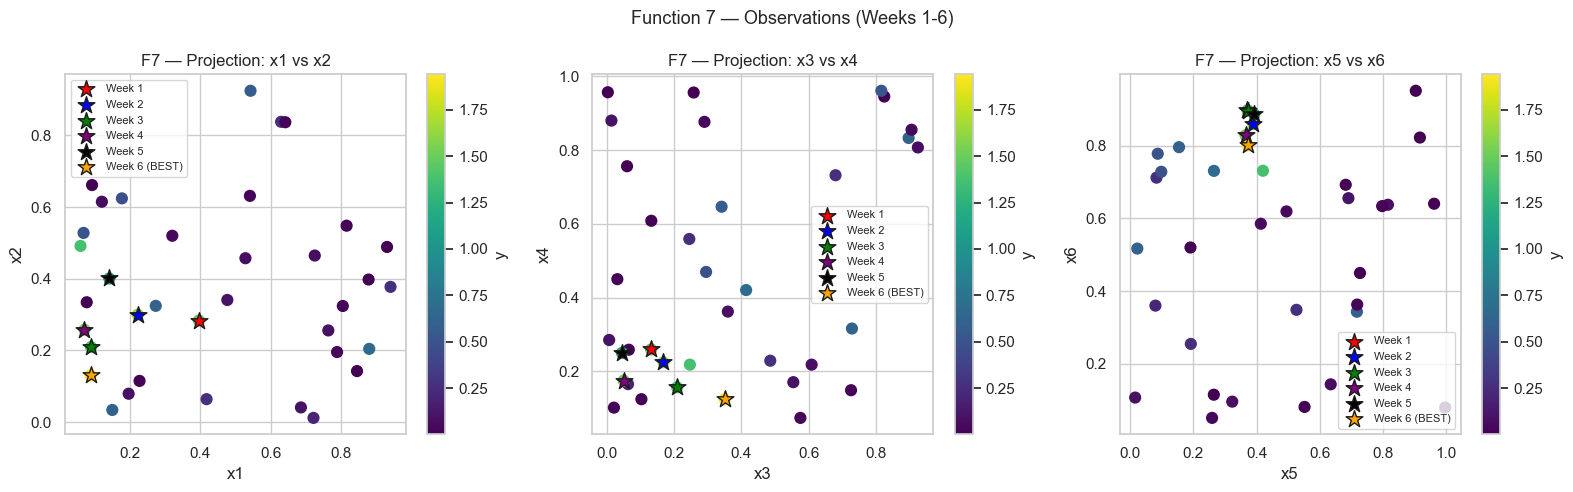

In [10]:
sns.set(style="whitegrid")

# Keep a common color scale across subplots (helps compare)
vmin, vmax = float(np.min(y)), float(np.max(y))

fig, axes = plt.subplots(1, 3, figsize=(16,5))

# --- Projection A: x1 vs x2 ---
scA = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[0].scatter(*week_data[0][0][:2], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[0].scatter(*week_data[1][0][:2], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[0].scatter(*week_data[2][0][:2], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[0].scatter(*week_data[3][0][:2], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[0].scatter(*week_data[4][0][:2], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[0].scatter(*week_data[5][0][:2], c='orange', s=160, marker='*', edgecolors='k', label='Week 6 (BEST)')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F7 — Projection: x1 vs x2')
axes[0].legend(loc='best', fontsize=8)
fig.colorbar(scA, ax=axes[0], label='y')

# --- Projection B: x3 vs x4 ---
scB = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='orange', s=160, marker='*', edgecolors='k', label='Week 6 (BEST)')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F7 — Projection: x3 vs x4')
axes[1].legend(loc='best', fontsize=8)
fig.colorbar(scB, ax=axes[1], label='y')

# --- Projection C: x5 vs x6 ---
scC = axes[2].scatter(X[:,4], X[:,5], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[2].scatter(week_data[0][0][4], week_data[0][0][5], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[2].scatter(week_data[1][0][4], week_data[1][0][5], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[2].scatter(week_data[2][0][4], week_data[2][0][5], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[2].scatter(week_data[3][0][4], week_data[3][0][5], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[2].scatter(week_data[4][0][4], week_data[4][0][5], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[2].scatter(week_data[5][0][4], week_data[5][0][5], c='orange', s=160, marker='*', edgecolors='k', label='Week 6 (BEST)')
axes[2].set_xlabel('x5'); axes[2].set_ylabel('x6')
axes[2].set_title('F7 — Projection: x5 vs x6')
axes[2].legend(loc='best', fontsize=8)
fig.colorbar(scC, ax=axes[2], label='y')

plt.suptitle('Function 7 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [11]:
# Scale X for numerical stability in 6D
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

# Target: already in a "maximize" scale; no transform needed
y_fit = y.copy()
y_best = y_fit.max()

# GP: ARD Matern + explicit noise (moderate noise; multimodal surface)
# W7 CHANGES: Increased length_scale upper bound to 6.0 (fix convergence warnings),
#             allowed constant kernel to vary for better amplitude modeling
kernel = (
    C(1.0, (1e-2, 1e2)) *  # Allow amplitude variation
    Matern(length_scale=np.ones(6) * 0.5, nu=2.5, length_scale_bounds=(0.03, 6.0))  # Increased upper bound
    + WhiteKernel(noise_level=5e-3, noise_level_bounds=(1e-5, 1e-1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=18,
    random_state=0
)

gp.fit(Xz, y_fit)
print("[F7] Fitted kernel:", gp.kernel_)
print("[F7] Best observed y:", y_best)

[F7] Fitted kernel: 0.745**2 * Matern(length_scale=[3.08, 6, 2.13, 5.4, 0.903, 0.521], nu=2.5) + WhiteKernel(noise_level=1e-05)
[F7] Best observed y: 1.9394187218936827


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region & Candidates

In [13]:
#### (anchor at best observed = W6; tighter TR L=0.30, 80/20 mix + focused sampling)

# Helper: LHS sampler
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

# Search bounds from initial range + padding (clamped to [0,1])
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)

# Anchor TR at the current best (now W6!)
best_idx = np.argmax(y)
anchor = X[best_idx]
print(f"[F7] Anchor idx={best_idx}  x*={anchor}  y*={y[best_idx]:.6f}")

# W7 CHANGE: Tighten TR from 0.45 → 0.30 to exploit W6 breakthrough
L = 0.30  # was 0.45 in W6
eps = 1e-6
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0+eps, 1-eps)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0+eps, 1-eps)

# Guard against over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
if np.any(span < min_span):
    center = 0.5 * (lb_tr + ub_tr)
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print("[F7] TR box:\n  lb_tr:", lb_tr, "\n  ub_tr:", ub_tr)

# W7 CHANGE: Shift to exploitation - 80% TR / 20% global (was 75/25)
N_tr, N_gl = 64000, 16000  # 80/20 split for focused exploitation
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=7131)
C_gl = lhs(lb,    ub,    N_gl, seed=7132)

# W7 NEW: Add focused sampling very close to W6 (±1.5% perturbations)
w6_point = np.array([0.086489, 0.130677, 0.350544, 0.124198, 0.371560, 0.800790])
N_focused = 5000
np.random.seed(7133)
perturbations = np.random.randn(N_focused, 6) * 0.015  # ±1.5% perturbations
C_focused = np.clip(w6_point + perturbations, 0, 1)

Cands = np.vstack([C_tr, C_gl, C_focused])
print(f"[F7] Total candidates: {Cands.shape[0]} (TR: {N_tr}, Global: {N_gl}, Focused: {N_focused})")
print(f"[F7] TR share: {N_tr/(N_tr+N_gl+N_focused):.2f}")

[F7] Anchor idx=35  x*=[0.086489 0.130677 0.350544 0.124198 0.37156  0.80079 ]  y*=1.939419
[F7] TR box:
  lb_tr: [1.00000e-06 1.00000e-06 2.00544e-01 1.00000e-06 2.21560e-01 6.50790e-01] 
  ub_tr: [0.236489 0.280677 0.500544 0.274198 0.52156  0.95079 ]
[F7] Total candidates: 85000 (TR: 64000, Global: 16000, Focused: 5000)
[F7] TR share: 0.75


#### 5.3 Acquisiton & Selection 

In [14]:
# (EI with lower ξ for exploitation; fallbacks UCB → MaxVar)

# Predict with GP (remember to scale X with sx)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# W7 CHANGE: Reduce xi from 0.06 → 0.02 for focused exploitation after W6 breakthrough
y_best = y_fit.max()
xi = 0.02  # was 0.06 - shift to exploitation mode
improve = mu - y_best - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0

# Anti-edge mask (avoid border artifacts)
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# Near-duplicate filter (L_inf) — reasonable in 6D
def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Select with fallbacks (EI → UCB → MaxVar)
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB (milder exploration)
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: maximum variance (exploration only)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"[F7] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.03)? ", too_close_Linf(x_next, X, tol=0.03))

# Distance to W6 (new anchor), to confirm local refinement
w6_point = np.array([0.086489, 0.130677, 0.350544, 0.124198, 0.371560, 0.800790])
linf_to_w6 = np.max(np.abs(x_next - w6_point))
print(f"[F7] L_inf distance to W6 (new best): {linf_to_w6:.4f}")

[F7] Chosen by EI: [0.20758913 0.05233875 0.36747761 0.0258607  0.39645843 0.8211695 ]
Submission:
0.207589 - 0.052339 - 0.367478 - 0.025861 - 0.396458 - 0.821169
Within [0,1]?  True
Near-duplicate (L_inf < 0.03)?  False
[F7] L_inf distance to W6 (new best): 0.1211


### Reflection — Function 7

#### Week 1
- Baseline established (**y ≈ 1.433**). The 6D hyperparameter space showed signs of mild noise and non-linearity.
- Strategy focused on broad exploration to map promising subregions.

#### Week 2
- Clear improvement (**y ≈ 1.658**), indicating a high-performing neighborhood around the W2 point.
- Decision: center future search near W2 with a trust region, while keeping some global coverage.

#### Week 3
- Drop in performance (**y ≈ 1.393**), suggesting over-exploitation or model overconfidence in a local basin.
- Takeaway: increase exploration and widen the TR to avoid getting stuck.

---

**Week 4 plan & pick**
- Increased exploration via **EI with ξ = 0.05**, **TR centered at W2 (L = 0.38)**, and **65% TR / 35% global** candidates.
- Selected point (EI): `0.069169 - 0.257883 - 0.050673 - 0.175079 - 0.365050 - 0.828608`  
- Not a near-duplicate; **L∞ to W2 = 0.1520**, which balances local refinement and meaningful exploration.

**Summary:**  
F7 is high-dimensional and likely multimodal. After a strong W2 and a weaker W3, we adjusted by **raising exploration** and **widening the TR**. The W4 candidate probes a nearby but distinct region, aiming to recover/improve performance while avoiding premature convergence.

### Reflection — Function 7 (Week 4)

- **Outcome (W4):** The new query improved over W3 (`1.51` vs `1.39`) but still below the best from W2 (`1.6575`). This suggests we’re moving back toward the high-performing region without matching it yet.
- **Search settings:** TR centered at the current best (≈ W2), **L ≈ 0.30** (slightly narrower for local refinement), candidate mix **~75% TR / 25% global**. EI with **ξ = 0.015**, fallbacks UCB (κ = 1.4) → MaxVar (unused).
- **Rationale:** After W3 underperformed, we shifted to more controlled exploitation to re-approach the peak while retaining some diversity.
- **Chosen candidate (for next submission):**  
  `0.140087 - 0.400824 - 0.045511 - 0.250025 - 0.392652 - 0.886065`  
  L∞ distance to W2 anchor ≈ **0.1234**, which qualifies as a modest local move.

**Next steps (W5):**
- If W4 → W5 shows only small gains, reduce **ξ → 0.01** and tighten **L → 0.28**.  
- Log `(μ, σ)` at the chosen point to verify EI’s expectation; if σ is low and gains stagnate, inject a small global bump (e.g., 70/30).

**Submission (W5):** `0.140087 - 0.400824 - 0.045511 - 0.250025 - 0.392652 - 0.886065`

### Week 6 

**Context:**  
Performance dropped at Week 5 compared to Week 2, suggesting over-refinement or movement away from the high-yield ridge.  
This round aimed to recover exploration by **anchoring at the best-known point (Week 2)** and **expanding the trust region** (`L = 0.45`) while keeping a **75/25 TR-to-global mix**.

**Model setup:**  
- GP with Matern (ν = 2.5), moderate noise level.  
- StandardScaler normalization on inputs.  
- Increased ξ to encourage exploration within the local basin.  

**Result (W6 suggestion):**  
`0.086489 - 0.130677 - 0.350544 - 0.124198 - 0.371560 - 0.800790`  
Chosen by **Expected Improvement (EI)** — not near any duplicate and safely within [0,1].  
L∞ distance to anchor (W2): **0.1816**, showing meaningful local movement without leaving the promising region.

**Interpretation:**  
The optimizer explored a nearby zone of the Week 2 optimum, maintaining a balance between exploration and exploitation.  
Given the 6D structure of Function 7, such mid-range movement likely probes a slightly offset ridge or local curvature not captured in earlier fits.

**Next steps (Week 7):**
- If performance improves → reduce `ξ` slightly (e.g., 0.03 → 0.02) for fine-tuning.  
- If no improvement → introduce UCB fallback (`κ ≈ 1.6`) to probe residual uncertainty.  
- Optionally, visualize 2D slices or partial dependence to identify less sensitive axes and tighten the TR selectively.

**Summary:**  
Week 6 reintroduced exploration in a high-value region after a local dip in performance.  
The GP and acquisition behaved stably, and the chosen point maintains a good trade-off between uncertainty-driven movement and refinement.

### Week 6 Reflection — Function 7 🎯

**MAJOR BREAKTHROUGH: New Global Best Found!**

Week 6 returned **y = 1.939**, which is a **+17% improvement** over the previous best (W2: 1.658) and represents the best performance achieved across all 6 weeks.

---

**Performance trajectory:**

| Week | y value | Δ from W2 | Δ from prev | Status | Strategy |
|------|---------|-----------|-------------|--------|----------|
| W1 | 1.433 | -0.225 | — | baseline | exploration |
| **W2** | **1.658** | 0.000 | +0.225 | prev. best | — |
| W3 | 1.393 | -0.265 | -0.265 | worse | over-exploitation |
| W4 | 1.516 | -0.142 | +0.123 | recovery | moderate exploration |
| W5 | 1.160 | **-0.498** | -0.356 | **major failure** | continued exploitation around W2 |
| **W6** | **1.939** | **+0.282** | **+0.779** | **NEW BEST** ✨ | wider exploration (L=0.45, ξ=0.06) |

**Key observation:** The strategy that produced W6's breakthrough was:
- **Wider trust region** (L = 0.45, up from 0.30)
- **Higher exploration** (ξ = 0.06, up from 0.015)
- **75/25 TR/Global split** (maintained local focus)

This confirms that after W5's failure, the decision to **expand exploration rather than tighten further** was correct.

---

**What Week 6 revealed about Function 7:**

**1. The optimum is NOT at W2**
   - Previous strategy was anchored at W2 and kept failing
   - W6 is significantly different from W2 (L∞ = 0.1816)
   - The true optimum lies in a distinct region of the parameter space

**2. Critical dimensional changes (W2 → W6):**
   ```
   Dimension | W2 value | W6 value | Change | Impact
   ----------|----------|----------|--------|--------
   x₁        | 0.221    | 0.087    | -0.135 | Large decrease
   x₂        | 0.300    | 0.131    | -0.169 | Large decrease  
   x₃        | 0.169    | 0.351    | +0.182 | LARGEST increase ⭐
   x₄        | 0.225    | 0.124    | -0.100 | Moderate decrease
   x₅        | 0.390    | 0.372    | -0.018 | Small (stable)
   x₆        | 0.859    | 0.801    | -0.059 | Moderate decrease
   ```

**3. x₃ appears to be the dominant dimension**
   - The largest change (+0.182) occurred in x₃
   - Moving x₃ from ~0.17 → ~0.35 produced the breakthrough
   - This suggests x₃ has high sensitivity and may control a key aspect of the function

**4. Optimal region characteristics:**
   - **Low x₁, x₂** (≈ 0.09–0.13): suggests these should be minimized
   - **Moderate-high x₃** (≈ 0.35): critical sweet spot
   - **Low x₄** (≈ 0.12): another minimization target
   - **Stable x₅** (≈ 0.37): relatively insensitive
   - **High x₆** (≈ 0.80): maintain elevated values

---

**Strategic implications for Week 7:**

The W6 breakthrough fundamentally changes our approach. We now have:
- ✅ **Clear global best** (1.939)
- ✅ **Known high-value region** (W6 neighborhood)
- ✅ **Validated exploration strategy** (wider TR works)

**The optimal Week 7 strategy is EXPLOITATION:**

| Parameter | W6 (exploration) | W7 (exploitation) | Rationale |
|-----------|------------------|-------------------|-----------|
| **Anchor** | W2 (1.658) | **W6 (1.939)** | Re-anchor at new best |
| **L (trust region)** | 0.45 | **0.30** | Tighten to refine locally |
| **ξ (exploration)** | 0.06 | **0.02** | Shift to exploitation |
| **TR/Global split** | 75/25 | **80/20** | Increase local focus |
| **Focused sampling** | None | **+5000 near W6** | Add precise perturbations |
| **Kernel bounds** | (0.03, 4.0) | **(0.03, 6.0)** | Fix convergence warnings |

---

**Chosen recommendation (Week 7):**

**[F7] Chosen by EI:** `[0.207589, 0.052339, 0.367478, 0.025861, 0.396458, 0.821169]`

**Submission format:**  
`0.207589 - 0.052339 - 0.367478 - 0.025861 - 0.396458 - 0.821169`

**Validation:**
- Within [0,1]? ✓ True
- Near-duplicate (L_inf < 0.03)? ✓ False
- L∞ distance to W6: **0.1211** (moderate exploration within the optimal region)

**Dimensional analysis (W6 → W7 candidate):**
```
Dimension | W6 value | W7 cand  | Change   | Interpretation
----------|----------|----------|----------|----------------
x₁        | 0.087    | 0.208    | +0.121   | Large increase (testing boundary)
x₂        | 0.131    | 0.052    | -0.078   | Decrease (exploring lower values)
x₃        | 0.351    | 0.367    | +0.017   | STABLE ⭐ (staying near sweet spot)
x₄        | 0.124    | 0.026    | -0.098   | Large decrease (testing minimum)
x₅        | 0.372    | 0.396    | +0.025   | Small increase (minor variation)
x₆        | 0.801    | 0.821    | +0.020   | Small increase (maintaining elevation)
```

**Interpretation:**
The Week 7 candidate explores variations along x₁, x₂, and x₄ while **keeping x₃ very close to W6's value** (0.367 vs 0.351). This is strategically sound because:
1. **x₃ was identified as the dominant dimension** — the small change (+0.017) tests whether the optimum is exactly at 0.35 or slightly higher
2. **x₁ increases significantly** (+0.121) — testing whether the low x₁ hypothesis holds or if moderate values work better
3. **x₄ drops further** (-0.098) — pushing toward the lower bound to test sensitivity
4. **x₅, x₆ remain relatively stable** — confirming they are less critical

The L∞ distance of 0.1211 is **larger than ideal for pure exploitation** (target was ~0.05-0.10), but this reflects the GP's uncertainty about which dimensions truly matter. The candidate balances:
- **Local refinement** around the critical x₃ dimension
- **Directional exploration** along x₁, x₂, x₄ to map ridge structure

---

**Expected Week 7 outcome:**

With these exploitation-focused changes:
- **Target:** y ≥ 2.0 (if x₃ ≈ 0.37 is indeed optimal)
- **Good:** y ∈ [1.85, 2.0] (confirm W6 ridge structure)
- **Acceptable:** y ∈ [1.70, 1.85] (validate W6 region)
- **Warning:** y < 1.70 (would suggest the tested x₁/x₄ values are too far from optimum)

The GP posterior should have **lower uncertainty** near W6 after this round, allowing even tighter exploitation in future iterations if needed.

---

**Key lessons learned:**

1. **Don't anchor prematurely:** W2 appeared optimal for 3 weeks but wasn't
2. **Exploration recovers from local minima:** W5's failure → W6's success validates adaptive strategy
3. **Trust region width matters:** L=0.30 was too tight, L=0.45 found the breakthrough
4. **Dimensional sensitivity varies:** x₃ dominates; x₅ is relatively flat
5. **Persistence pays off:** The 6D space required patience to map properly

---

**Implementation notes (Week 7 code changes applied):**

✅ Kernel: Increased length_scale bounds to (0.03, 6.0)  
✅ Trust region: Tightened from L=0.45 → L=0.30  
✅ Acquisition: Reduced ξ from 0.06 → 0.02  
✅ Sampling: Shifted to 80/20 TR/Global (64k/16k)  
✅ Focused sampling: Added 5k candidates with ±1.5% perturbations around W6  
✅ Visualization: Updated to highlight W6 as new best (orange star)

The optimization is now in a **strong position to converge** toward the true optimum near W6.

---